In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder containing JSON files
folder_path = "/workspace/datasets/apollo/car_models_json"

# List all JSON files in the folder
json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

#set seed for reproducibility
np.random.seed(0)

In [2]:
print("Number of JSON files found: ", len(json_files))

Number of JSON files found:  79


Load point cloud and meshes from jsons

In [3]:
from scipy.spatial.distance import cdist

def load_point_clouds(folder_path, json_files, N):
    point_clouds = {'SUV': [], '3x': [], '2x': []}
    titles = {'SUV': [], '3x': [], '2x': []}  # To store titles
    for i, json_file_name in enumerate(json_files[:N]):
        with open(os.path.join(folder_path, json_file_name)) as json_file:
            data = json.load(json_file)
            vertices = np.array(data['vertices'])
            # Adjust vertices for plotting: swap Y and Z, then negate the new Z
            vertices = vertices[:, [0, 2, 1]]  # Swap Y and Z
            vertices[:, 2] = -vertices[:, 2]   # Negate the new Z
            point_clouds[data['car_type']].append(vertices)
            titles[data['car_type']].append(json_file_name)  # Store the file name as title
    return point_clouds, titles

def load_meshes(folder_path, json_files, N):
    meshes = {'SUV': [], '3x': [], '2x': []}
    titles = {'SUV': [], '3x': [], '2x': []}  # To store titles
    for i, json_file_name in enumerate(json_files[:N]):
        with open(os.path.join(folder_path, json_file_name)) as json_file:
            data = json.load(json_file)
            vertices = np.array(data['vertices'])
            faces = np.array(data['faces']) - 1  # Convert to 0-based indexing
            # Adjust vertices for plotting: swap Y and Z, then negate the new Z
            vertices = vertices[:, [0, 2, 1]]  # Swap Y and Z
            vertices[:, 2] = -vertices[:, 2]   # Negate the new Z
            meshes[data['car_type']].append((vertices, faces))
            titles[data['car_type']].append(json_file_name)  # Store the file name as title
    return meshes, titles

def chamfer_distance(pc1, pc2):
    dist_matrix = cdist(pc1, pc2, 'euclidean')
    return np.mean(dist_matrix.min(axis=1)) + np.mean(dist_matrix.min(axis=0))

In [4]:
point_cloud_list, point_cloud_titles = load_point_clouds(folder_path, json_files, len(json_files))
meshes_list, mesh_titles = load_meshes(folder_path, json_files, len(json_files))
print("Number of SUVs: ", len(point_cloud_list['SUV']))
print("Number of 3x: ", len(point_cloud_list['3x']))
print("Number of 2x: ", len(point_cloud_list['2x']))

Number of SUVs:  34
Number of 3x:  30
Number of 2x:  15


Visualizing our data our points clouds and meshes

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_point_clouds(point_clouds, titles, num_cols=3):
    sns.set(style="whitegrid")
    num_clouds = len(point_clouds)
    num_rows = (num_clouds + num_cols - 1) // num_cols
    colors = plt.cm.jet(np.linspace(0, 1, num_clouds))
    fig = plt.figure(figsize=(num_cols * 5, num_rows * 5))
    for i, pc in enumerate(point_clouds, start=1):
        ax = fig.add_subplot(num_rows, num_cols, i, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])
        ax.set_title(titles[i-1])  # Set the title for each subplot
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_zlim([0, 5])
    plt.tight_layout()
    plt.show()

def display_meshes(meshes, titles, num_cols=3):
    sns.set(style="whitegrid")
    num_meshes = len(meshes)
    num_rows = (num_meshes + num_cols - 1) // num_cols
    colors = plt.cm.jet(np.linspace(0, 1, num_meshes))
    fig = plt.figure(figsize=(num_cols * 5, num_rows * 5))
    for i, (vertices, faces) in enumerate(meshes, start=1):
        ax = fig.add_subplot(num_rows, num_cols, i, projection='3d')
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces, linewidth=0.2, antialiased=True, color=colors[i-1])
        ax.set_title(titles[i-1])  # Set the title for each subplot
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_zlim([0, 5])
    plt.tight_layout()
    plt.show()


Display point cloud and mesh for one of each cartype, mesh consists of verticies and faces, points cloud just contains vertices

/tmp/ipykernel_14581/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


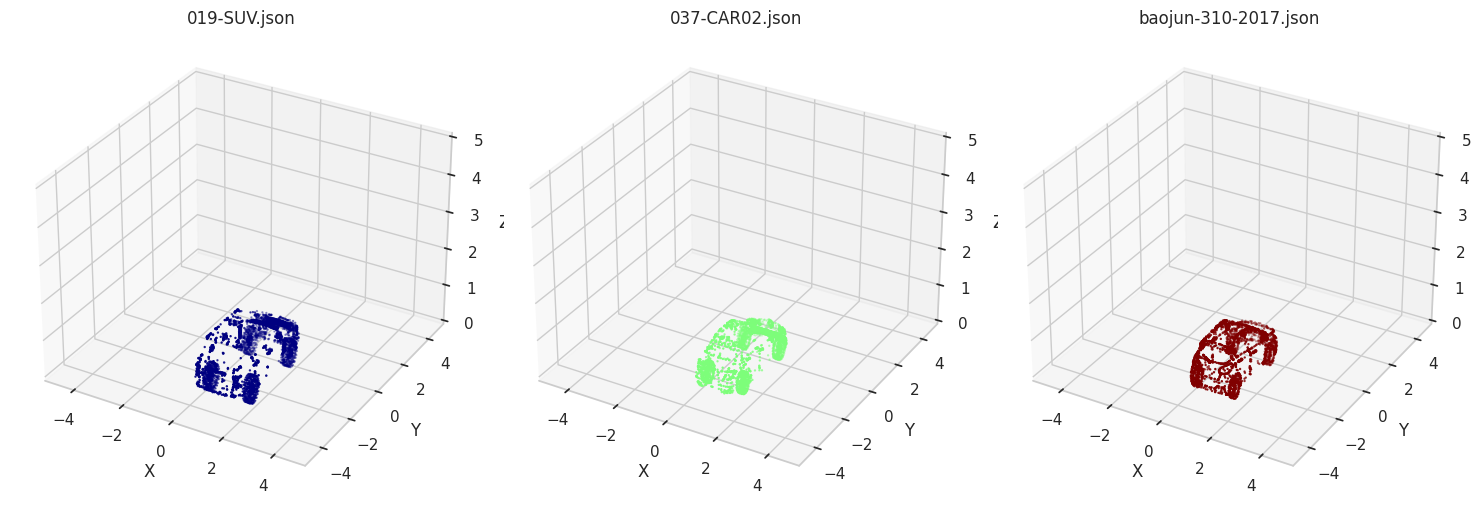

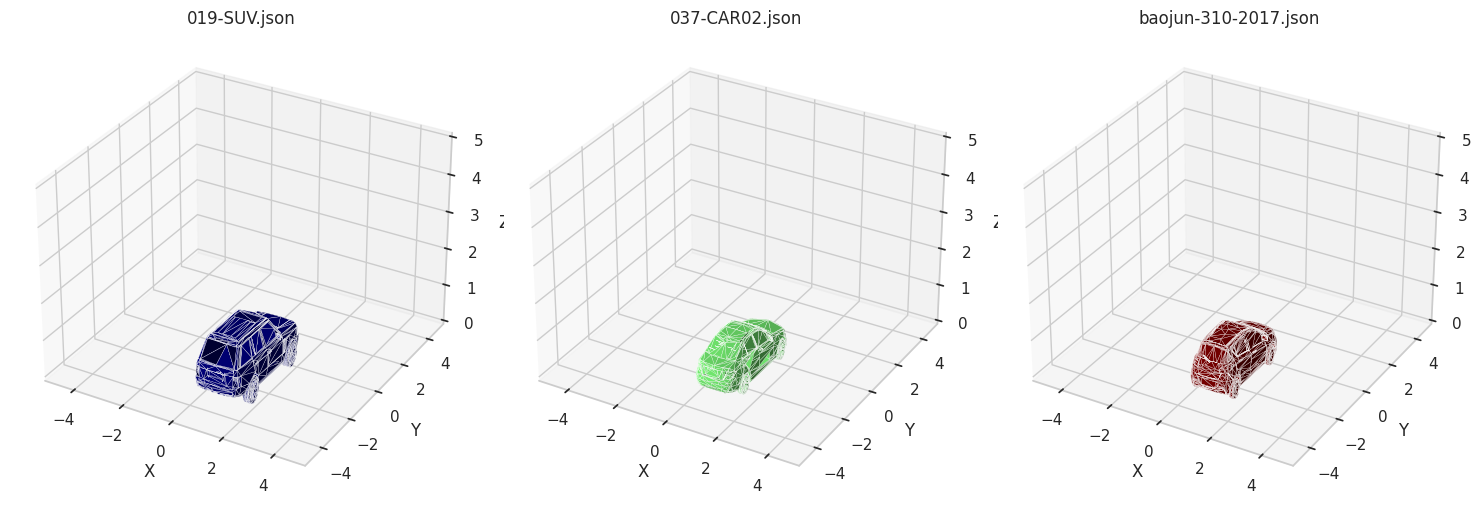

In [6]:
display_point_clouds([point_cloud_list["SUV"][0],point_cloud_list["3x"][0],point_cloud_list["2x"][0]], [point_cloud_titles["SUV"][0],point_cloud_titles["3x"][0],point_cloud_titles["2x"][0]])
display_meshes([meshes_list["SUV"][0],meshes_list["3x"][0],meshes_list["2x"][0]], [mesh_titles["SUV"][0],mesh_titles["3x"][0],mesh_titles["2x"][0]])

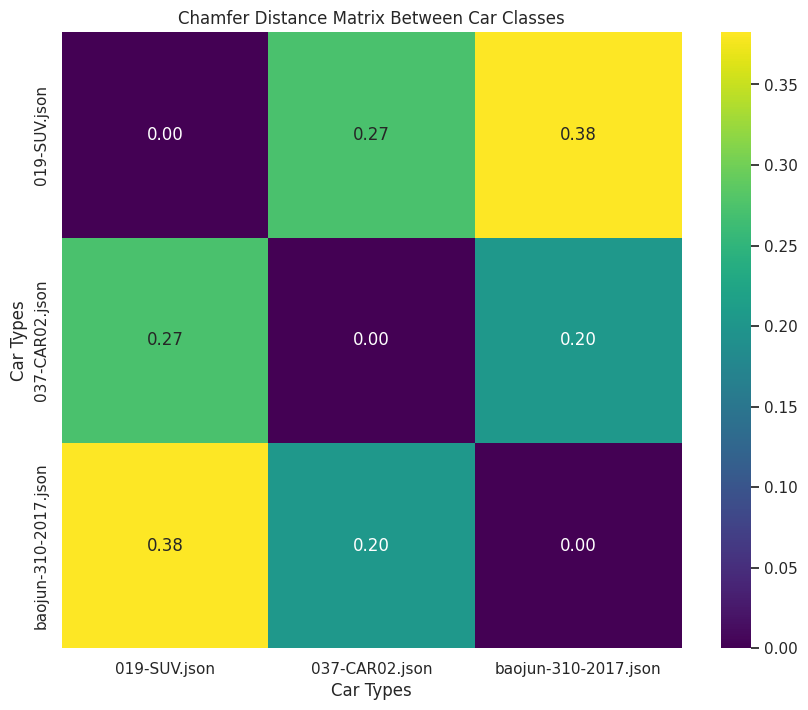

In [7]:
# List of car types and their respective first car point cloud
car_types = ['SUV', '3x', '2x']
point_clouds = [point_cloud_list[car_type][0] for car_type in car_types]  # First car point cloud from each type
titles = [point_cloud_titles[car_type][0] for car_type in car_types]  # Titles for each car

# Calculate the Chamfer distance between each pair of cars
distances = np.zeros((len(point_clouds), len(point_clouds)))
for i in range(len(point_clouds)):
    for j in range(len(point_clouds)):
        if i != j:
            distances[i, j] = chamfer_distance(point_clouds[i], point_clouds[j])
        else:
            distances[i, j] = 0  # Distance with itself is 0

# Plotting the Chamfer distances matrix using Seaborn's heatmap
sns.set(style="white")
plt.figure(figsize=(10, 8))
ax = sns.heatmap(distances, annot=True, fmt=".2f", cmap="viridis", xticklabels=titles, yticklabels=titles)
plt.title('Chamfer Distance Matrix Between Car Classes')
plt.xlabel('Car Types')
plt.ylabel('Car Types')
plt.show()

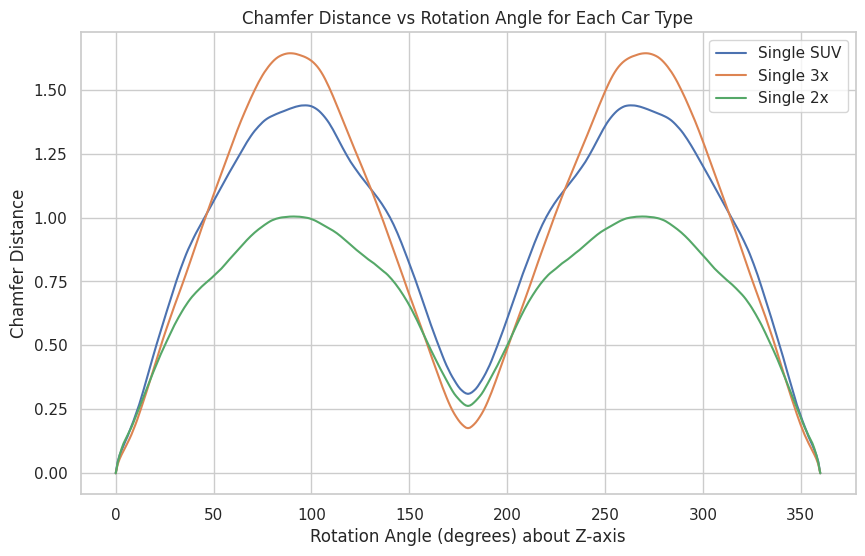

In [8]:
def rotate_point_cloud_z(pc, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians), 0],
        [np.sin(angle_radians), np.cos(angle_radians), 0],
        [0, 0, 1]
    ])
    return np.dot(pc, rotation_matrix.T)

angles = np.arange(0, 361, 1)  # Angles from 0 to 360 degrees
car_types = ['SUV', '3x', '2x']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for car_type in car_types:
    original_pc = point_cloud_list[car_type][0]
    distances = []

    for angle in angles:
        rotated_pc = rotate_point_cloud_z(original_pc, angle)
        distance = chamfer_distance(original_pc, rotated_pc)
        distances.append(distance)

    sns.lineplot(x=angles, y=distances, label=f'Single {car_type}')

plt.xlabel('Rotation Angle (degrees) about Z-axis')
plt.ylabel('Chamfer Distance')
plt.title('Chamfer Distance vs Rotation Angle for Each Car Type')
plt.legend()
plt.show()

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


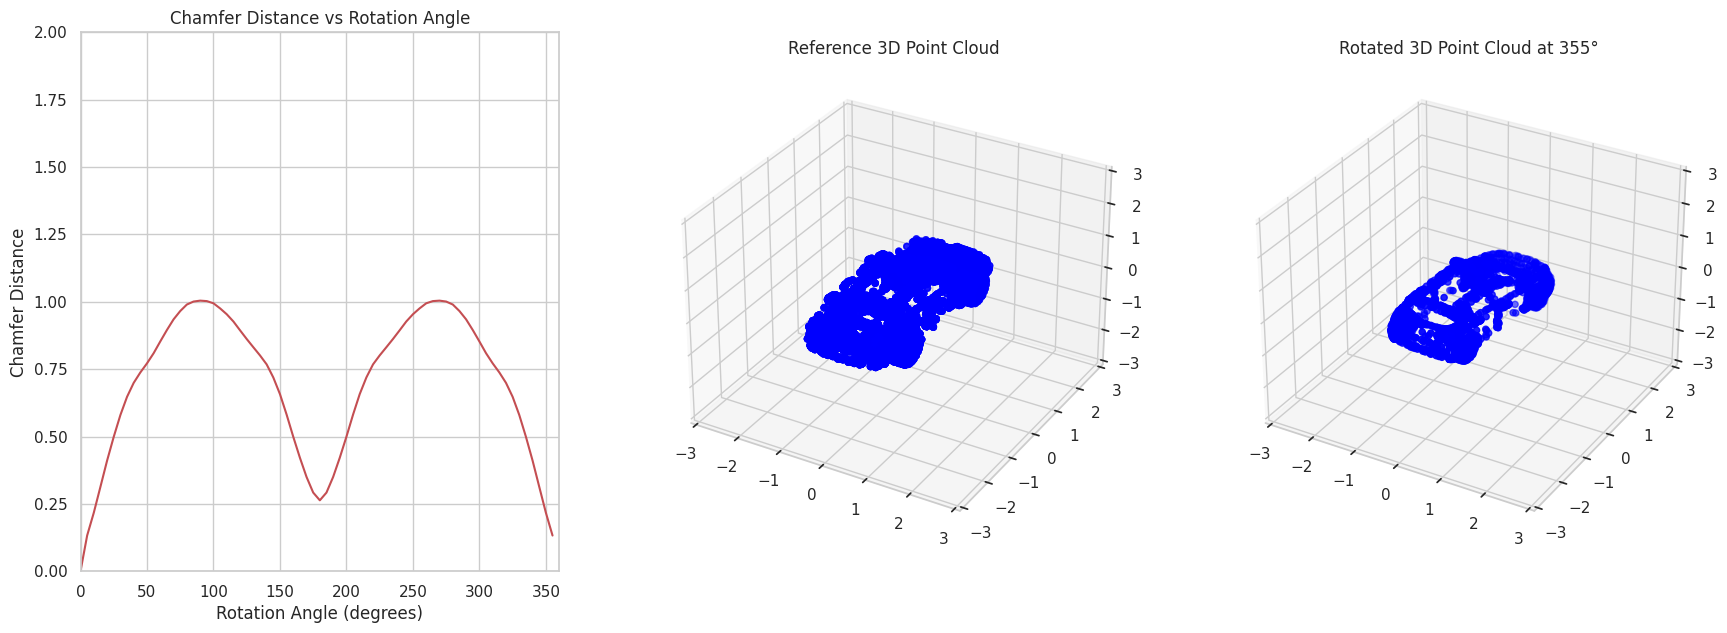

In [11]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis


distances = []

# Setup for plotting
norm = Normalize(vmin=0, vmax=360)
color_map = ScalarMappable(norm=norm, cmap='viridis')

fig = plt.figure(figsize=(21, 7))
ax_graph = fig.add_subplot(131)
ax_ref_pc = fig.add_subplot(132, projection='3d')
ax_rot_pc = fig.add_subplot(133, projection='3d')

line, = ax_graph.plot([], [], 'r-')
ax_graph.set_xlim(0, 360)
ax_graph.set_ylim(0, 2)  # Adjusted to a maximum value of 2
ax_graph.set_xlabel('Rotation Angle (degrees)')
ax_graph.set_ylabel('Chamfer Distance')
ax_graph.set_title('Chamfer Distance vs Rotation Angle')

def init():
    line.set_data([], [])
    color = 'blue'
    ax_ref_pc.scatter(original_pc[:, 0], original_pc[:, 1], original_pc[:, 2], c=color, marker='o')
    ax_ref_pc.set_title('Reference 3D Point Cloud')
    ax_ref_pc.set_xlim([-3, 3])
    ax_ref_pc.set_ylim([-3, 3])
    ax_ref_pc.set_zlim([-3, 3])
    return line,

def update(frame):
    angle = frame * 5
    rotated_pc = rotate_point_cloud_z(original_pc, angle)
    distance = chamfer_distance(original_pc, rotated_pc)
    distances.append(distance)
    
    # Update the line plot
    line.set_data(range(0, angle + 1, 5), distances[:frame + 1])
    
    # Update the rotated point cloud plot
    color = 'blue'
    ax_rot_pc.clear()
    ax_rot_pc.scatter(rotated_pc[:, 0], rotated_pc[:, 1], rotated_pc[:, 2], c=color, marker='o')
    ax_rot_pc.set_title(f'Rotated 3D Point Cloud at {angle}°')
    ax_rot_pc.set_xlim([-3, 3])
    ax_rot_pc.set_ylim([-3, 3])
    ax_rot_pc.set_zlim([-3, 3])
    
    return line,

# Create the animation
for car_type in car_types:
    original_pc = point_cloud_list[car_type][0]
    distances = []
    ani = FuncAnimation(fig, update, frames=range(72), init_func=init, blit=True, interval=100)

    # Display the animation
    HTML(ani.to_jshtml())

    # Save the animation as a GIF file
    ani.save(f'{car_type}_rotation_animation_z.gif', writer='Pillow', fps=10)



Can we optimize for random rotations?
The transformation matrix is defined as:

$$
\begin{bmatrix}
R_{xx} & R_{xy} & R_{xz} & T_x \\
R_{yx} & R_{yy} & R_{yz} & T_y \\
R_{zx} & R_{zy} & R_{zz} & T_z \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

**Components:**
- $R_{xx}, R_{yx}, R_{zx}$: Rotation around the x-axis.
- $R_{xy}, R_{yy}, R_{zy}$: Rotation around the y-axis.
- $R_{xz}, R_{yz}, R_{zz}$: Rotation around the z-axis.
- $T_x, T_y, T_z$: Translation along x, y, z axes.
- The last row $[0, 0, 0, 1]$ ensures operations in homogeneous coordinates.

__________________________________________
Since we are only optimizing the rotation for now the matrix is:
$$
\begin{bmatrix}
R_{xx} & R_{xy} & R_{xz} & 0 \\
R_{yx} & R_{yy} & R_{yz} & 0 \\
R_{zx} & R_{zy} & R_{zz} & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

In [12]:
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize

def transform_point_cloud_numpy(pc, transformation_matrix):
    # Add a column of ones to the point cloud to handle translations (homogeneous coordinates)
    homogeneous_pc = np.hstack([pc, np.ones((pc.shape[0], 1))])
    # Apply the transformation matrix to the point cloud
    transformed_homogeneous_pc = homogeneous_pc.dot(transformation_matrix.T)
    # Return only the x, y, z coordinates, not the homogeneous coordinate
    return transformed_homogeneous_pc[:, :3]

def build_transformation_matrix(rotation_vector, translation_vector):
    rotation_matrix = R.from_rotvec(rotation_vector).as_matrix()
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation_vector
    return transformation_matrix


In [13]:
reference_pc = point_cloud_list['3x'][0].copy()  # Reference point cloud

# Apply a random rotation to initial_pc
rotation_vector = R.random().as_rotvec()
translation_vector = np.zeros(3)  # Zero translation
initial_pc = transform_point_cloud_numpy(reference_pc.copy(), build_transformation_matrix(rotation_vector, translation_vector))

loss_history = []
print_loss=True
def objective_function_rotation(rotation_vector, initial_pc=initial_pc, reference_pc=reference_pc):
    """Objective function that optimizes only rotation."""
    transformation_matrix = build_transformation_matrix(rotation_vector, np.zeros(3))
    transformed_pc = transform_point_cloud_numpy(initial_pc, transformation_matrix)
    loss = chamfer_distance(transformed_pc, reference_pc)
    loss_history.append(loss)
    if print_loss:
        print(f'Loss: {loss}')
    return loss

# Setup for optimization with initial rotation vector randomized
initial_params = np.zeros(3)  # Initial parameters: only for rotation vector

# Perform optimization
result = minimize(objective_function_rotation, initial_params, method='BFGS')

Optimized transformations vector: [ 0.32098394 -1.4384966   1.98253016]


/tmp/ipykernel_14581/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


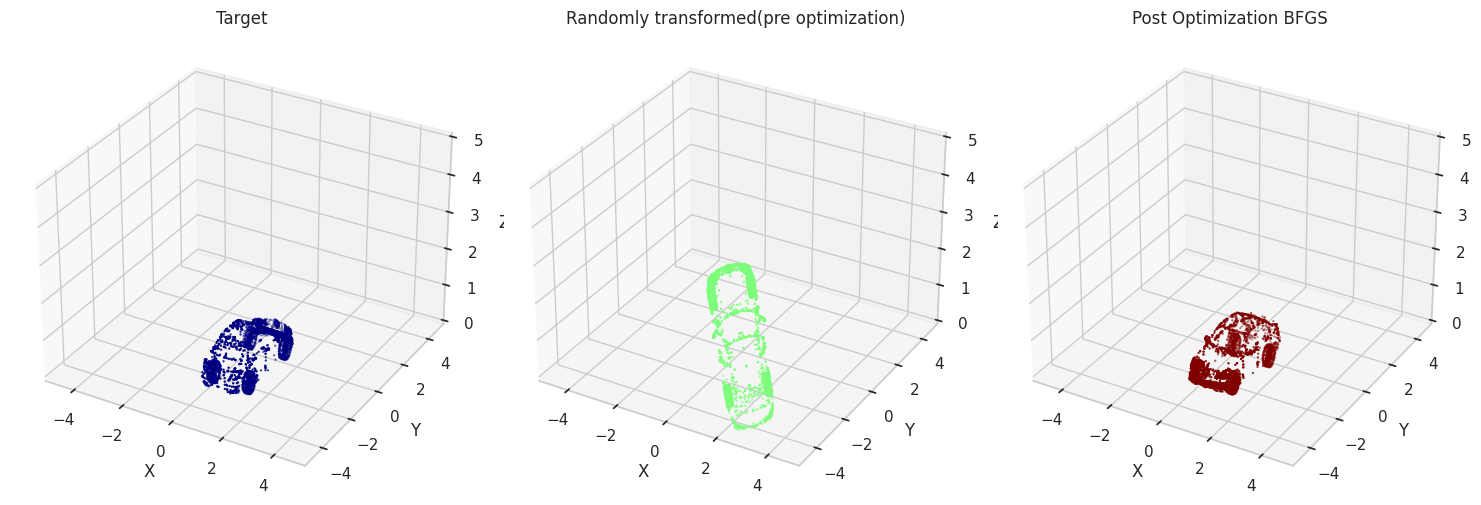

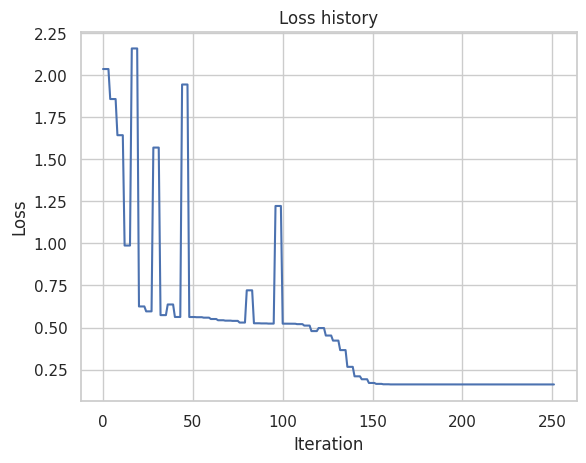

In [14]:
# Print final optimized rotation vector
print("Optimized transformations vector:", result.x)

# Plot original and final transformed point cloud
final_transformed_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(result.x[:3], np.zeros(3)))
display_point_clouds([reference_pc,initial_pc, final_transformed_pc,], ['Target','Randomly transformed(pre optimization)', 'Post Optimization BFGS'], num_cols=3)

# Plot the loss history
plt.figure()
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history')


plt.show()


In [37]:
#run optimization 10 times with different initializations
losses = []
rotation_vectors = []

reference_pc = point_cloud_list['3x'][0].copy()  # Reference point cloud
initial_pc = point_cloud_list['3x'][0].copy()  # Reference point cloud

#apply random rotation to initial_pc
initial_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(R.random().as_rotvec(), np.zeros(3)))


for i in range(10):
    initial_params = np.random.uniform(-np.pi, np.pi, 3)  # Random initialization
    loss_history = []
    result = minimize(objective_function_rotation, initial_params, method='L-BFGS-B')
    losses.append(result.fun)
    rotation_vectors.append(result.x)

/tmp/ipykernel_14581/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


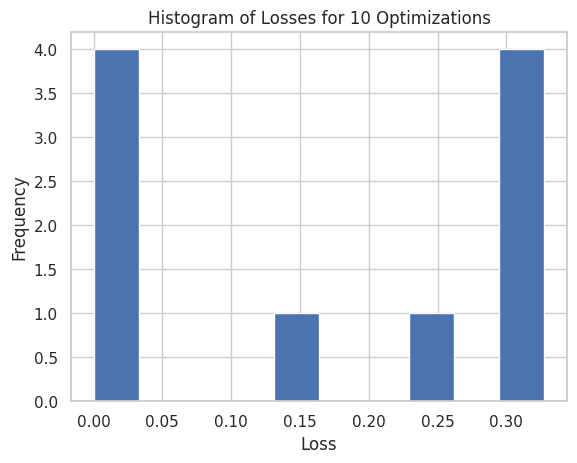

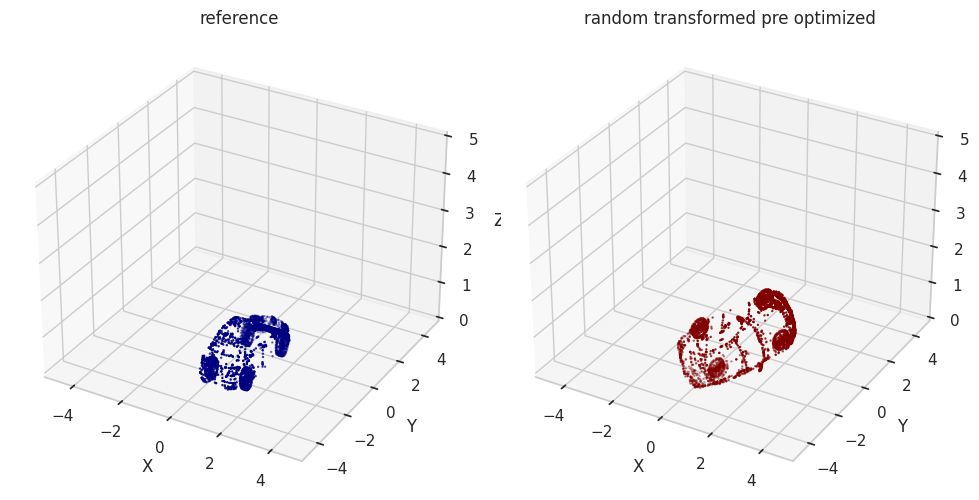

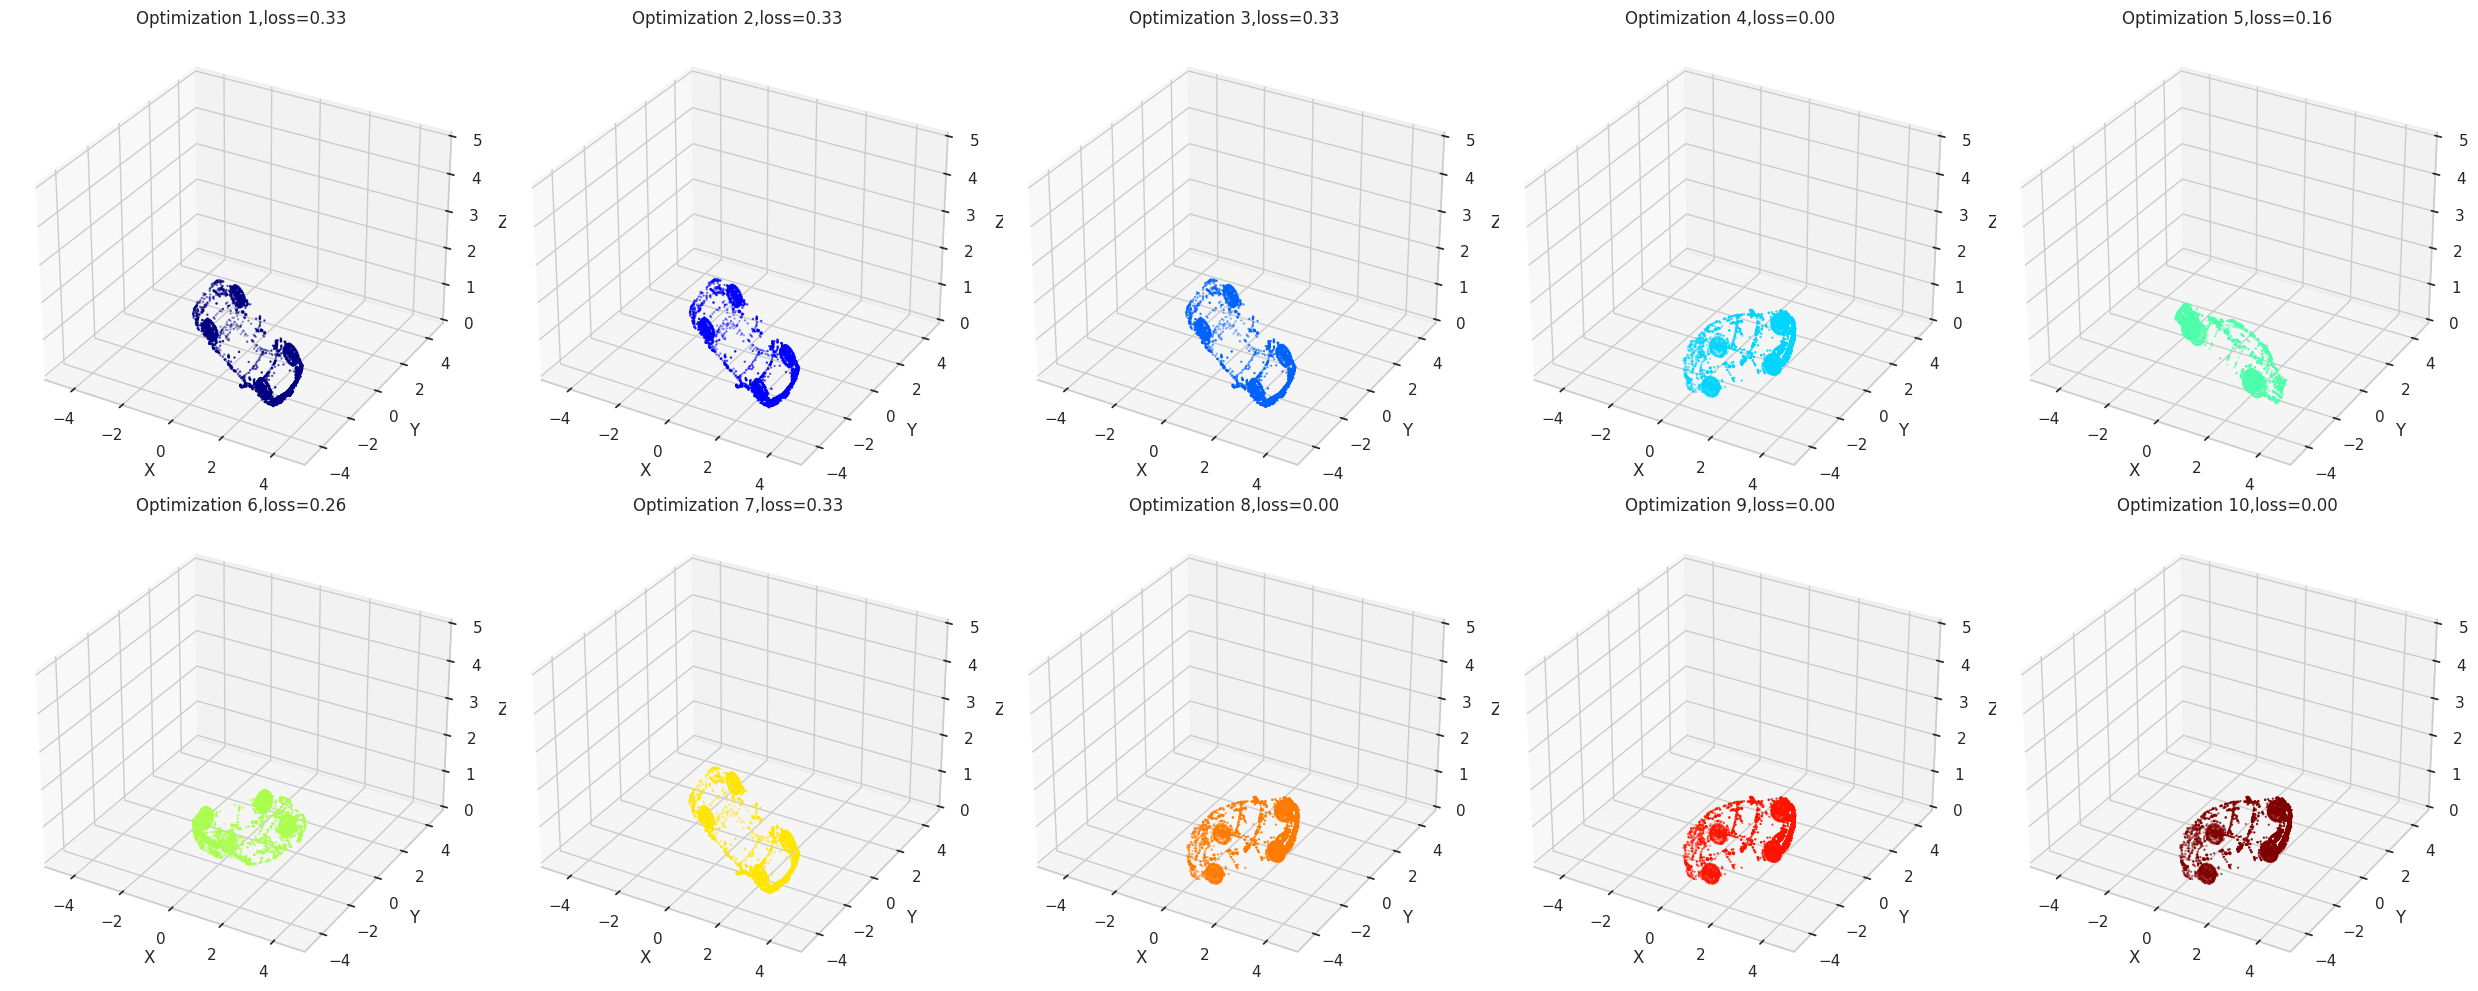

In [39]:
#show losses as histogram and display all transformations
plt.figure()
plt.hist(losses, bins=10)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Losses for 10 Optimizations')

# Display all transformations
transformed_point_clouds = []
titles = []
for i, rotation_vector in enumerate(rotation_vectors):
    transformed_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(rotation_vector, np.zeros(3)))
    transformed_point_clouds.append(transformed_pc)
    titles.append(f'Optimization {i+1},loss={losses[i]:.2f}')    

display_point_clouds([reference_pc,initial_pc], ["reference","random transformed pre optimized"], num_cols=2)

display_point_clouds(transformed_point_clouds, titles, num_cols=5)

/tmp/ipykernel_14581/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


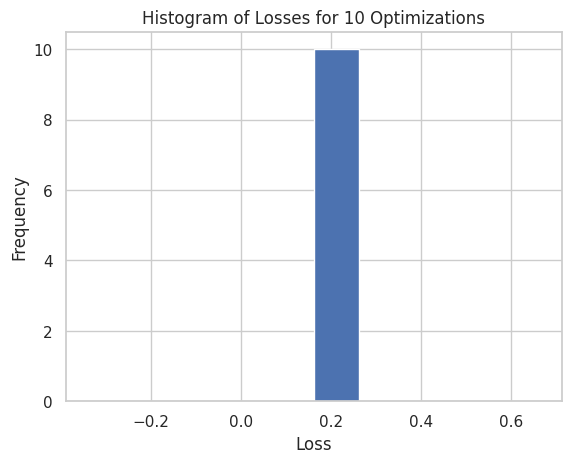

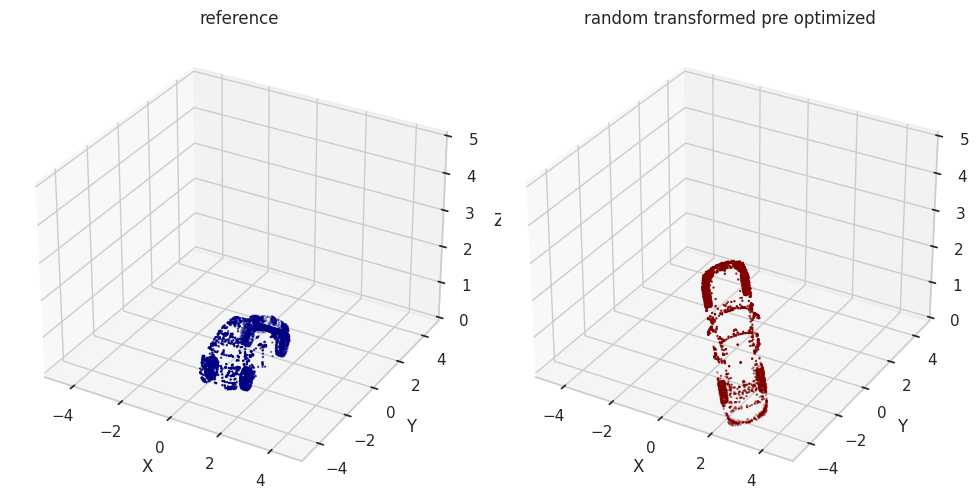

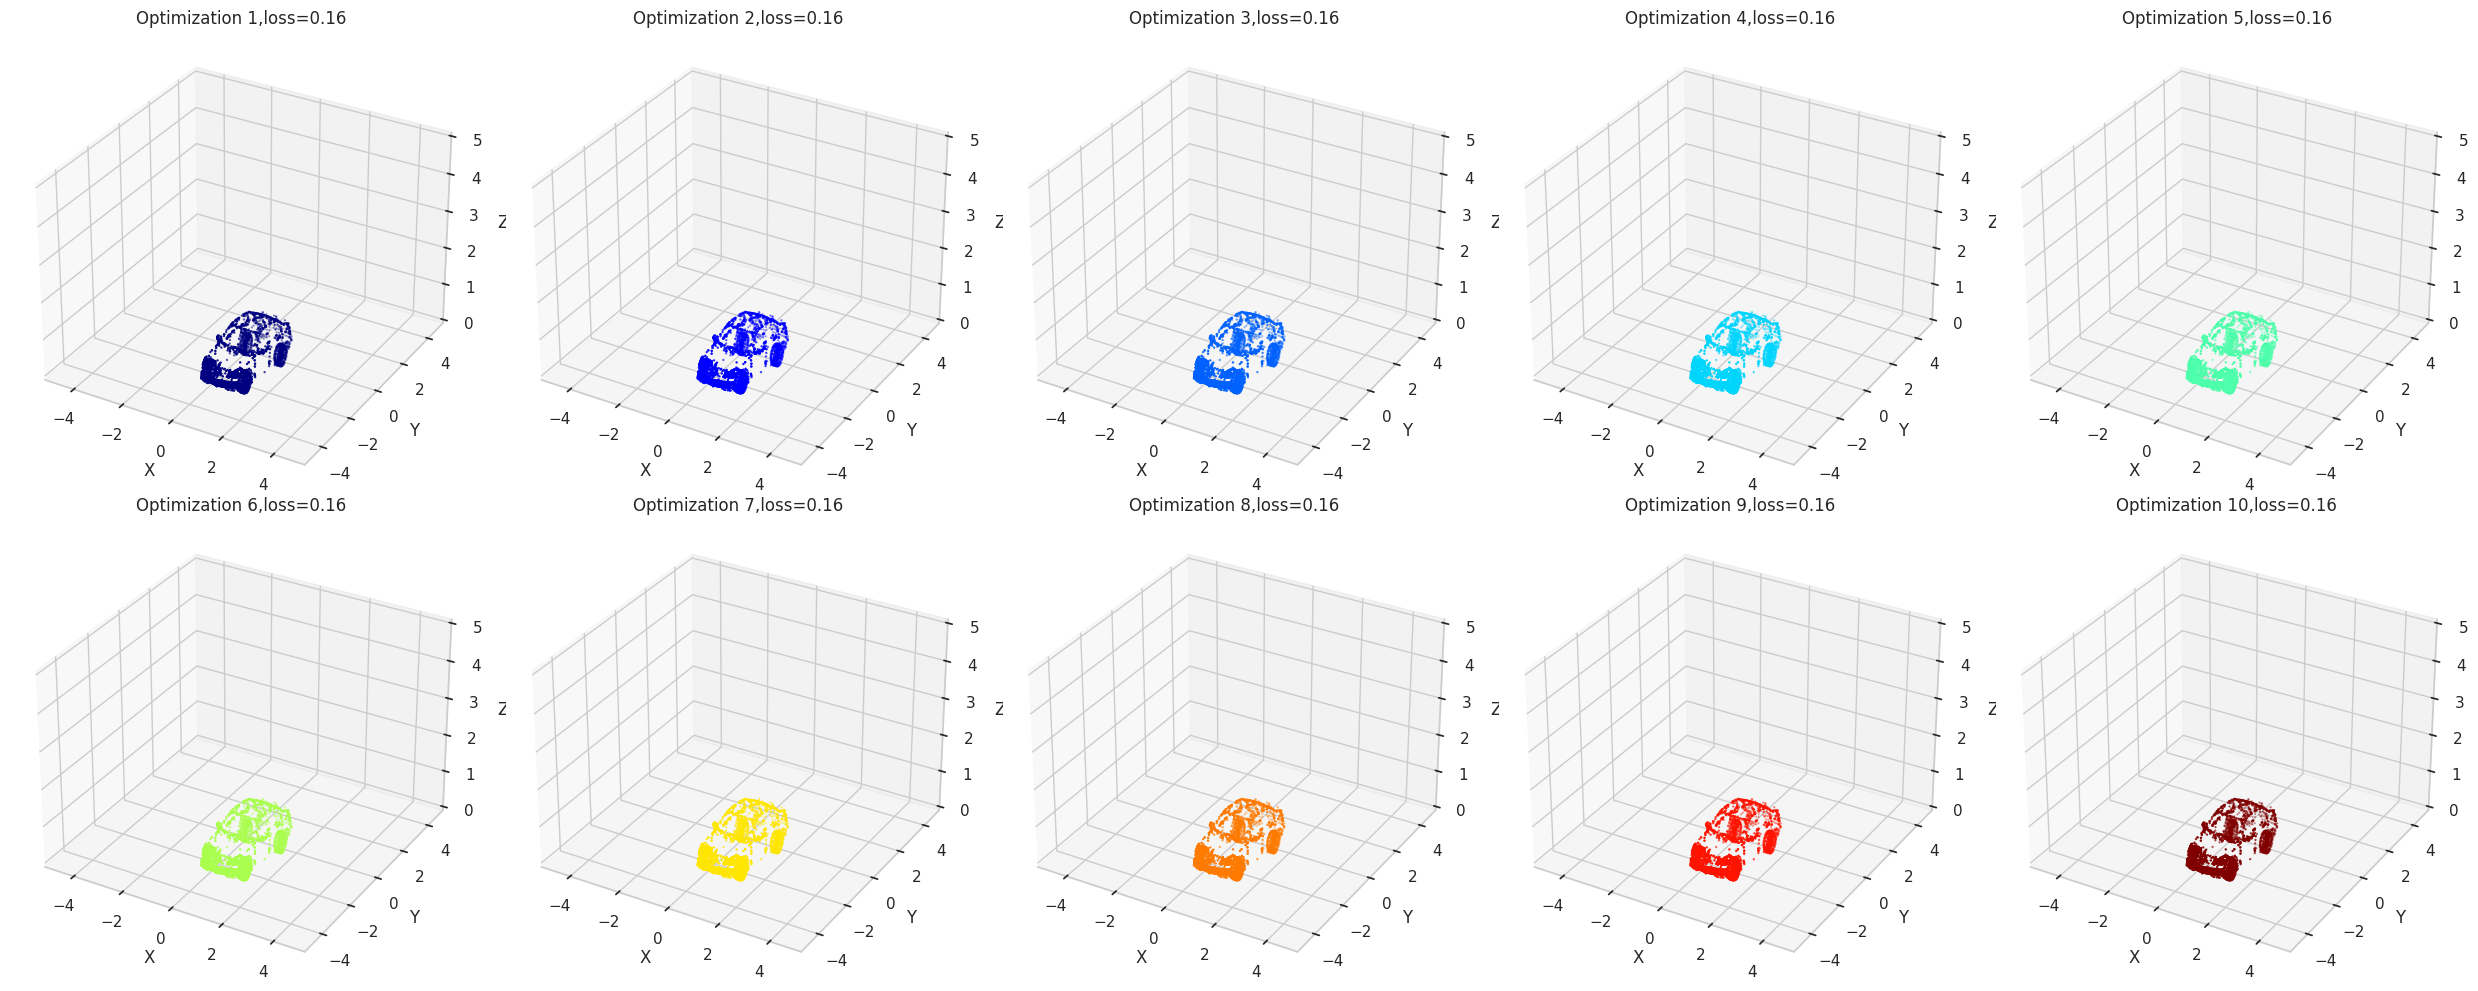

In [22]:
#do the same without intiializing random params
losses = []
rotation_vectors = []
for i in range(10):
    initial_params = np.zeros(3)  # Zero initialization
    loss_history = []
    result = minimize(objective_function_rotation, initial_params, method='BFGS')
    losses.append(result.fun)
    rotation_vectors.append(result.x)

#show losses as histogram and display all transformations
plt.figure()
plt.hist(losses, bins=10)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Losses for 10 Optimizations')

# Display all transformations
transformed_point_clouds = []
titles = []
for i, rotation_vector in enumerate(rotation_vectors):
    transformed_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(rotation_vector, np.zeros(3)))
    transformed_point_clouds.append(transformed_pc)
    titles.append(f'Optimization {i+1},loss={losses[i]:.2f}')

display_point_clouds([reference_pc,initial_pc], ["reference","random transformed pre optimized"], num_cols=2)

display_point_clouds(transformed_point_clouds, titles, num_cols=5)

can we escape this local minimum in the loss with a different optimization method?

In [ ]:
plt.figure()
loss_histories = []
optimized_point_clouds = []
optimization_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
initial_params = np.random.uniform(-np.pi, np.pi, 3)  # Random initialization
print("Initial Params: ", initial_params)
for method in optimization_methods:
    loss_history = []
    result = minimize(objective_function_rotation, initial_params, method=method)
    loss_histories.append(loss_history)
    optimized_point_clouds.append(transform_point_cloud_numpy(initial_pc, build_transformation_matrix(result.x[:3], np.zeros(3))))


Initial Params:  [0. 0. 0.]


<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_6961/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


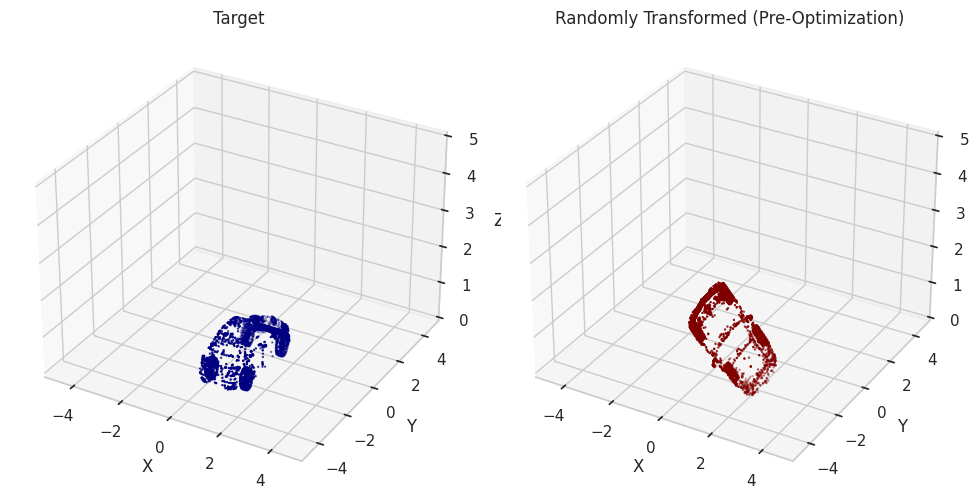

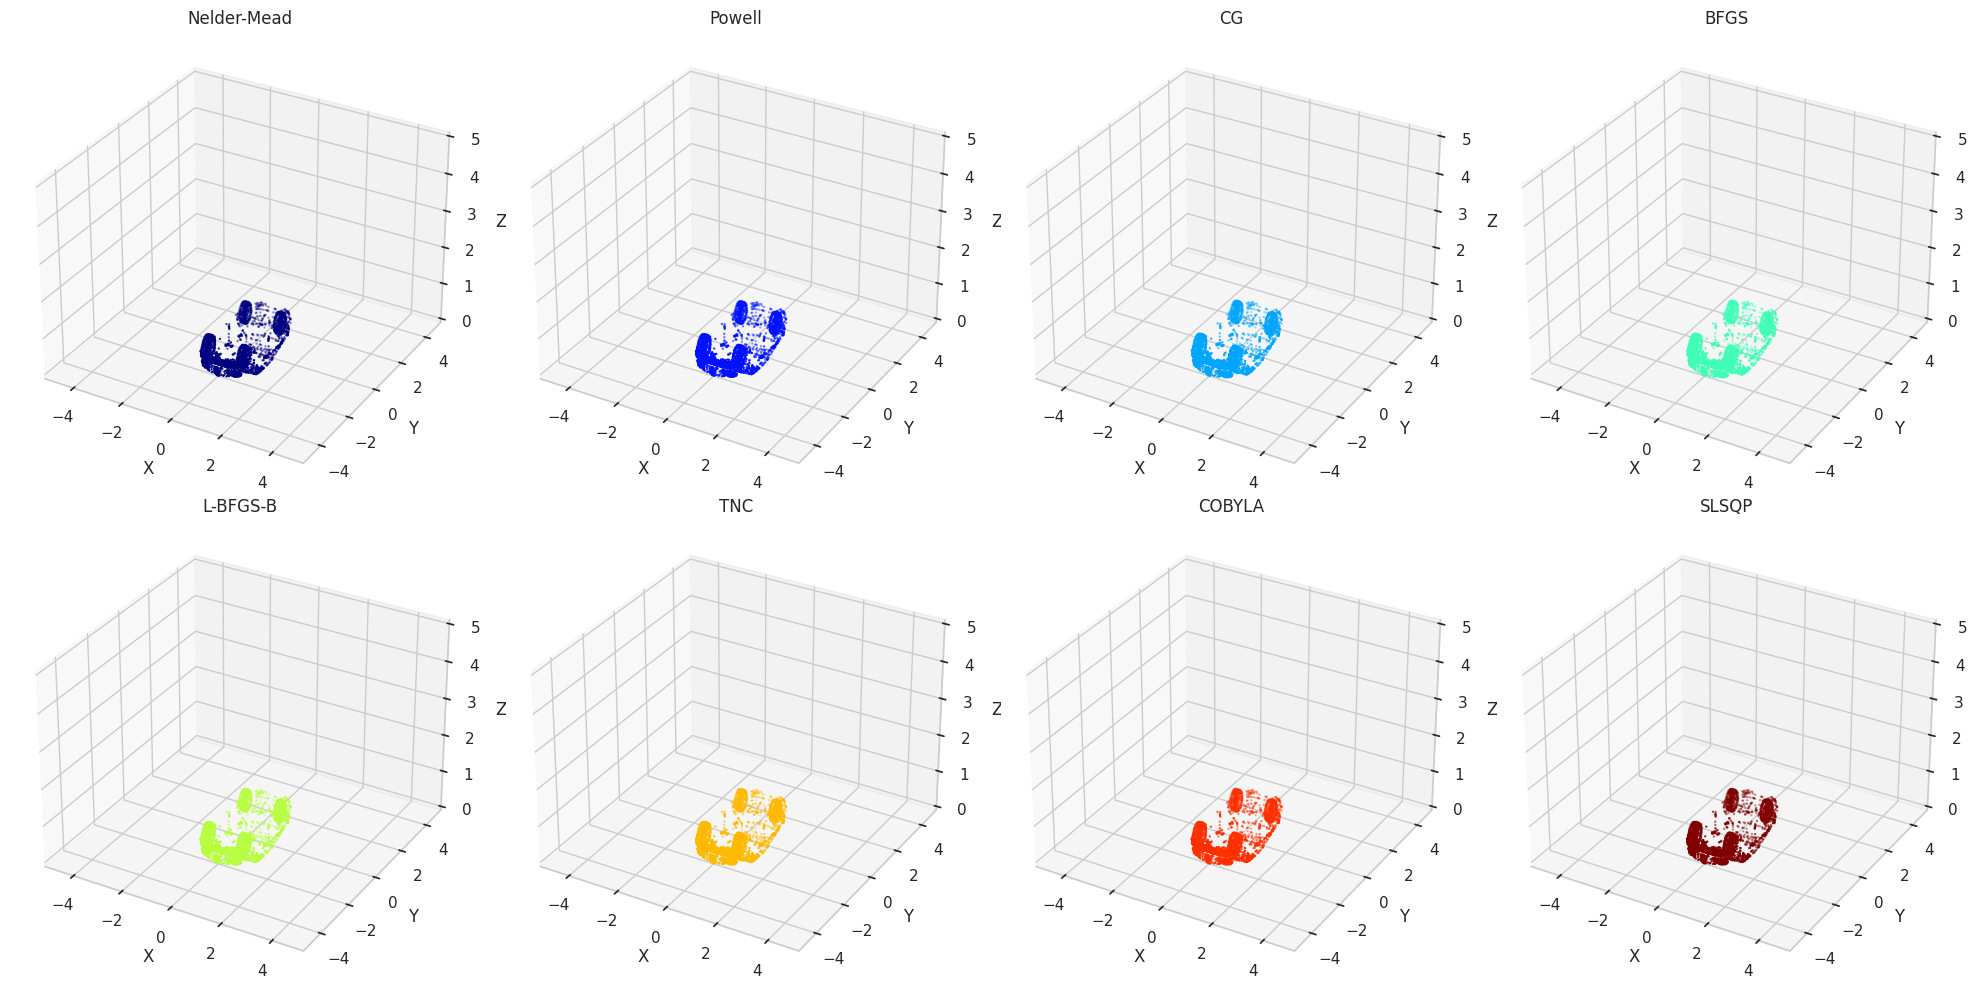

In [ ]:
#plot reference and pre transformed
display_point_clouds([reference_pc, initial_pc], ['Target', 'Randomly Transformed (Pre-Optimization)'], num_cols=2)
#plot transformed point clouds
display_point_clouds(optimized_point_clouds, optimization_methods, num_cols=4)

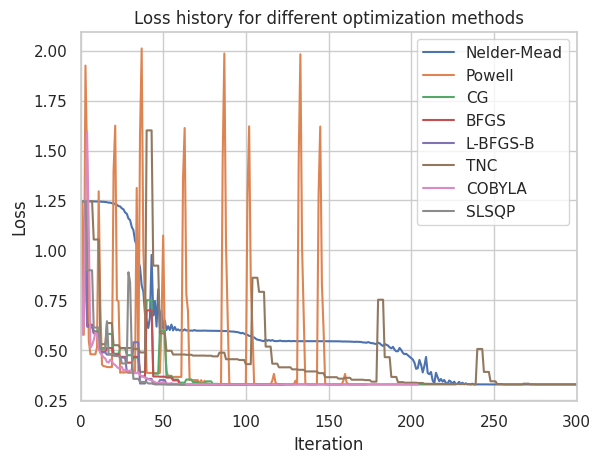

In [ ]:
# Plot the loss history for different optimization methods

for(loss_history, method) in zip(loss_histories, optimization_methods):
    plt.plot(loss_history, label=method)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history for different optimization methods')
plt.legend()
plt.xlim(0, 300)


plt.show()

We notice all methods are suffering from this getting caught in a local minimum, can we improve on all optimizations with by randomizing.

In [ ]:
from scipy.optimize import basinhopping

print("Initial Params: ", initial_params)

loss_histories_basin_hopping = []
optimized_point_clouds_basin_hopping = []
optimization_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

for method in optimization_methods:
    print(f"Using {method} as local minimizer in Basin Hopping...")
    loss_history = []
    # Setup the basin hopping optimizer
    minimizer_kwargs = {"method": method, "args": (initial_pc, reference_pc)}
    result = basinhopping(objective_function_rotation, initial_params, minimizer_kwargs=minimizer_kwargs, niter=10)
    loss_histories_basin_hopping.append(loss_history)
    optimized_point_clouds_basin_hopping.append(transform_point_cloud_numpy(initial_pc, build_transformation_matrix(result.x[:3], np.zeros(3))))


Initial Params:  [0. 0. 0.]
Using Nelder-Mead as local minimizer in Basin Hopping...
Using Powell as local minimizer in Basin Hopping...
Using CG as local minimizer in Basin Hopping...
Using BFGS as local minimizer in Basin Hopping...
Using L-BFGS-B as local minimizer in Basin Hopping...
Using TNC as local minimizer in Basin Hopping...
Using COBYLA as local minimizer in Basin Hopping...
Using SLSQP as local minimizer in Basin Hopping...


/tmp/ipykernel_6961/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


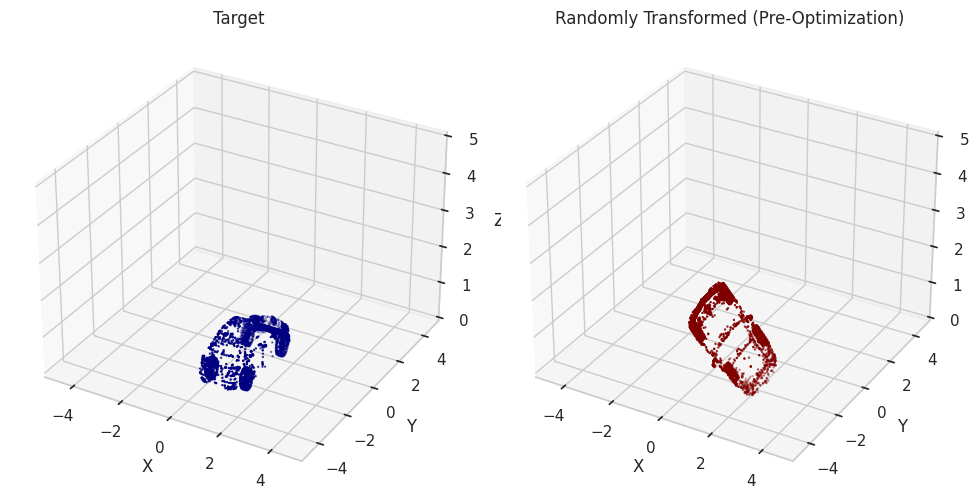

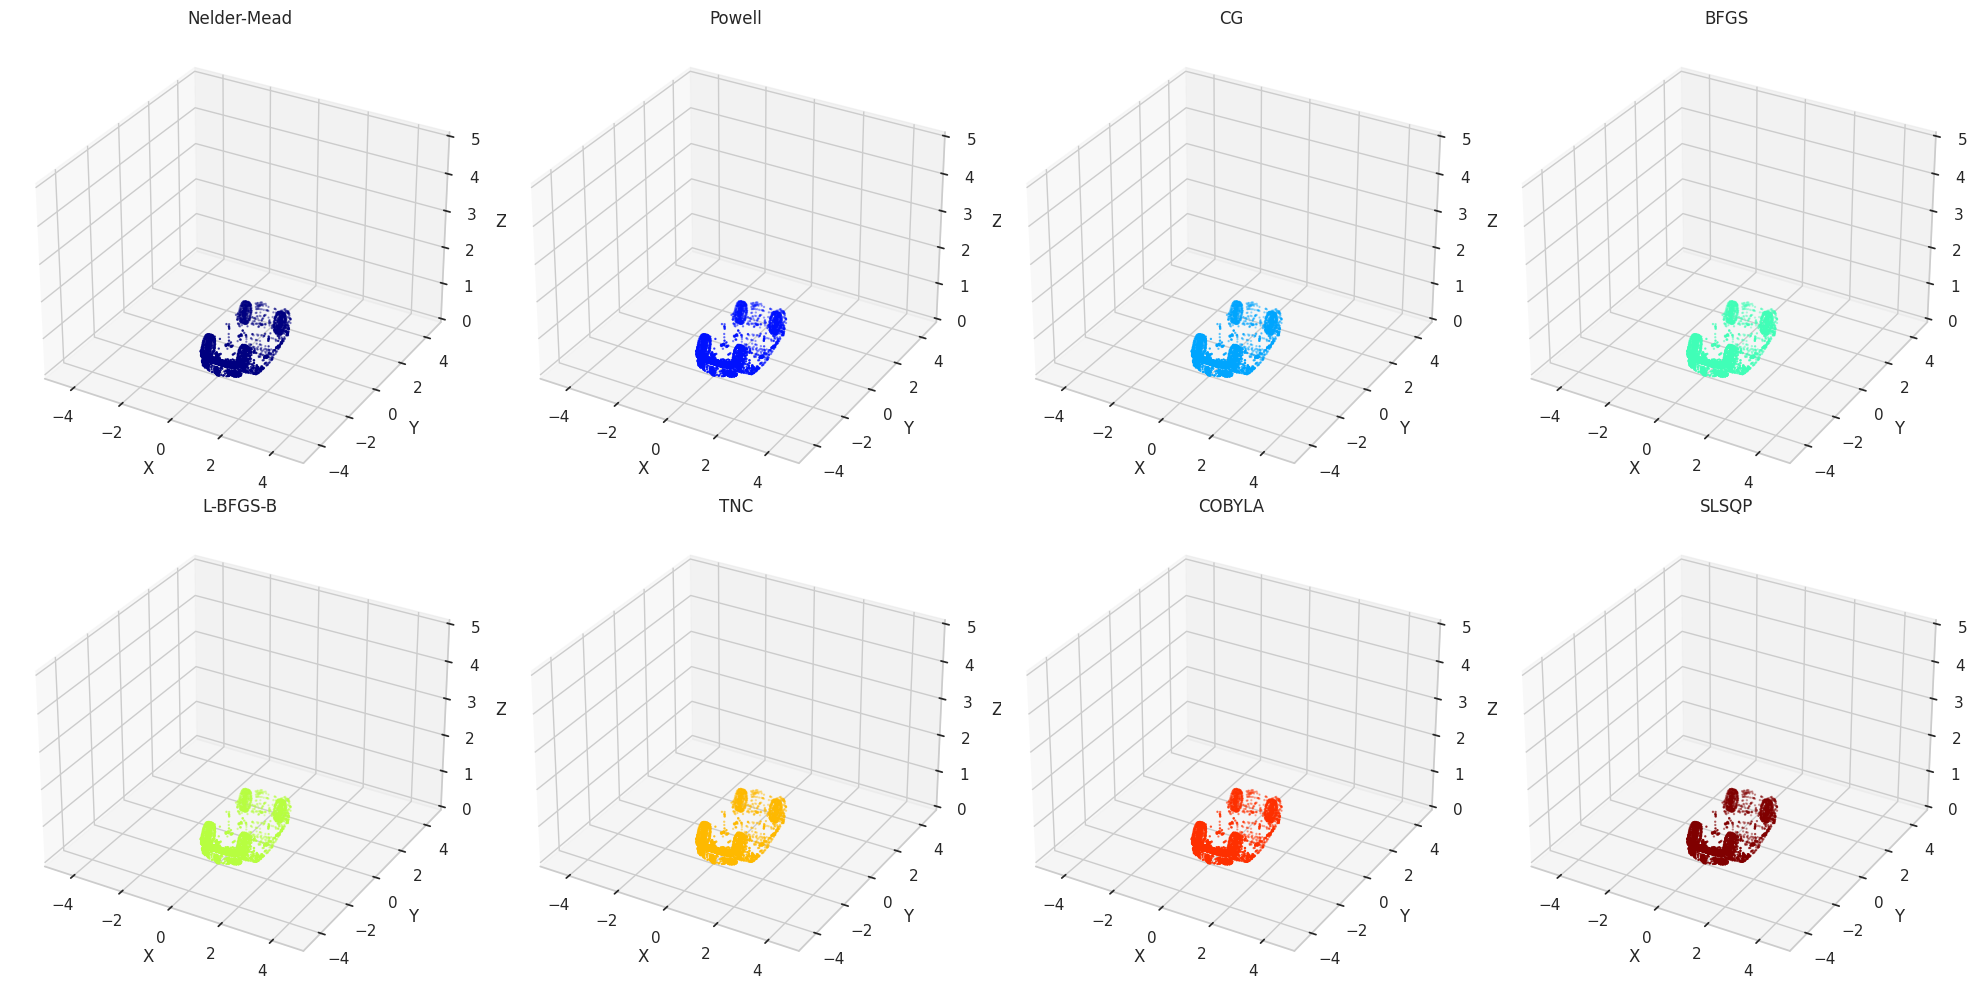

In [ ]:
#plot reference and pre transformed
display_point_clouds([reference_pc, initial_pc], ['Target', 'Randomly Transformed (Pre-Optimization)'], num_cols=2)
#plot transformed point clouds
display_point_clouds(optimized_point_clouds_basin_hopping, optimization_methods, num_cols=4)

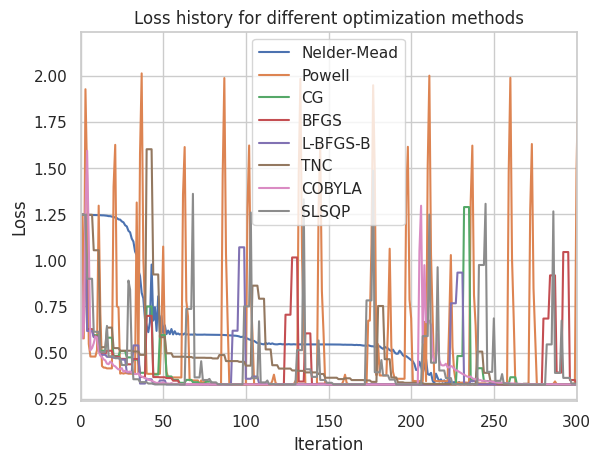

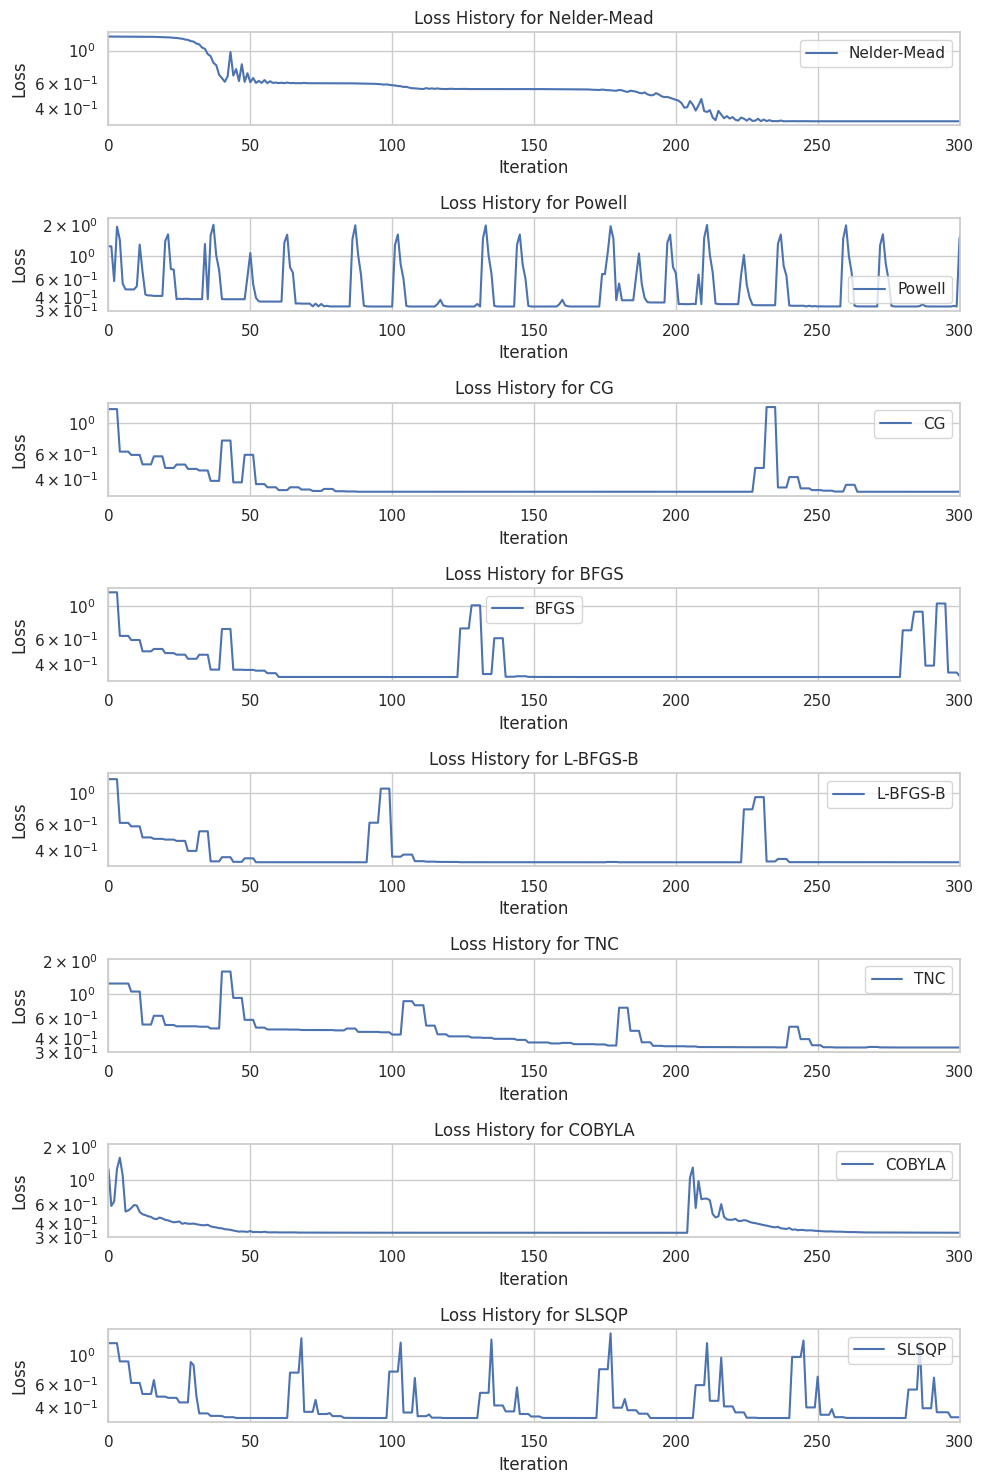

In [ ]:
for(loss_history, method) in zip(loss_histories_basin_hopping, optimization_methods):
    plt.plot(loss_history, label=method)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history for different optimization methods')
plt.legend()
plt.xlim(0, 300)
plt.show()


# Create a subplot for each optimization method
fig, axes = plt.subplots(nrows=len(optimization_methods), ncols=1, figsize=(10, 15))

for ax, loss_history, method in zip(axes, loss_histories_basin_hopping, optimization_methods):
    ax.plot(loss_history, label=method)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss History for {method}')
    ax.legend()
    ax.set_xlim(0, 300)  # Set the same x limit for all plots
    #log scale y axis
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

Basin with 10 iterations performs the same if not marginally worse

In [ ]:
print("Initial Params: ", initial_params)

loss_histories_basin_hopping = []
optimized_point_clouds_basin_hopping = []
optimization_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

for method in optimization_methods[-2:-1]:
    print(f"Using {method} as local minimizer in Basin Hopping...")
    loss_history = []
    # Setup the basin hopping optimizer
    minimizer_kwargs = {"method": method, "args": (initial_pc, reference_pc)}
    result = basinhopping(objective_function_rotation, initial_params, minimizer_kwargs=minimizer_kwargs, niter=20)
    loss_histories_basin_hopping.append(loss_history)
    optimized_point_clouds_basin_hopping.append(transform_point_cloud_numpy(initial_pc, build_transformation_matrix(result.x[:3], np.zeros(3))))

Initial Params:  [0. 0. 0.]
Using COBYLA as local minimizer in Basin Hopping...


Initial Params:  [ 2.04516651 -2.01234025  3.03531547]


Text(0.5, 1.0, 'Loss history for Differential Evolution')

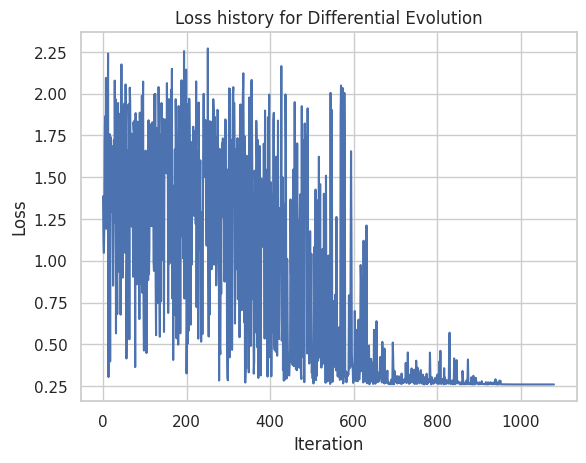

In [26]:
from scipy.optimize import differential_evolution
bounds = [(-np.pi, np.pi)] * 3  # Set bounds for each parameter within [-π, π]

plt.figure()
loss_history = []

method = 'Differential Evolution'
result = differential_evolution(objective_function_rotation, bounds)

transformation_matrix = build_transformation_matrix(result.x[:3], np.zeros(3))

#plot loss history
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss history for Differential Evolution')

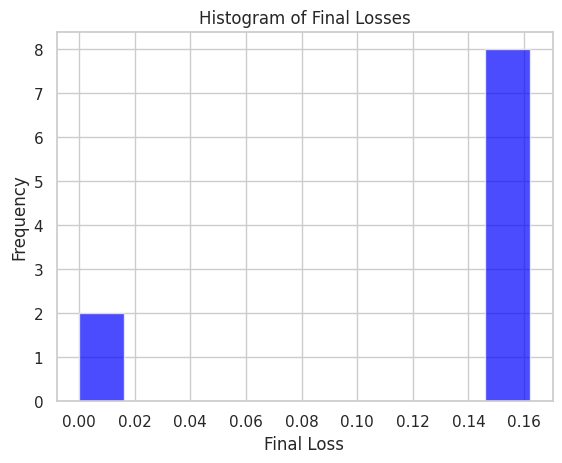

In [28]:
final_losses = []
bounds = [(-np.pi, np.pi)] * 3
for _ in range(10):
    result = differential_evolution(objective_function_rotation, bounds)
    transformation_matrix = build_transformation_matrix(result.x[:3], np.zeros(3))
    final_losses.append(result.fun)

# Plot histogram of final losses
plt.figure()
plt.hist(final_losses, bins=10, color='blue', alpha=0.7)
plt.xlabel('Final Loss')
plt.ylabel('Frequency')D
plt.title('Histogram of Final Losses')
plt.show()

/tmp/ipykernel_14581/782630147.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.5, c=colors[i-1])


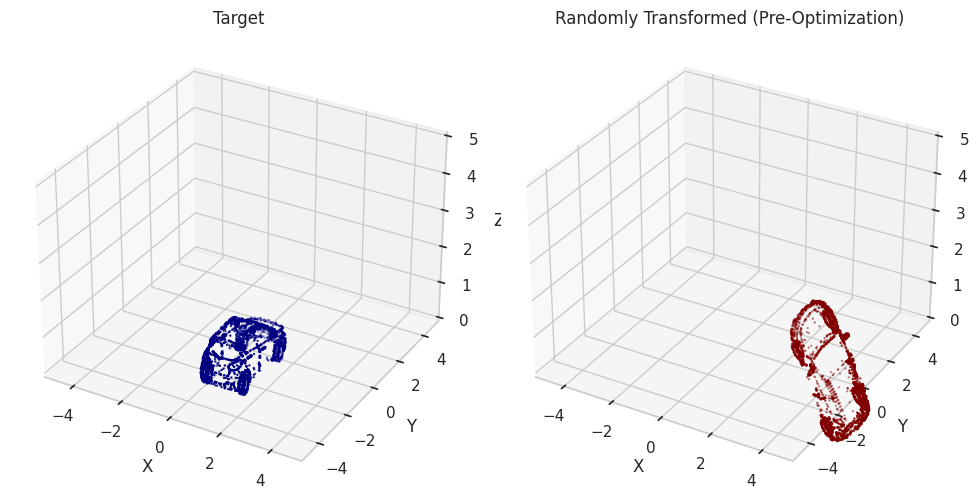

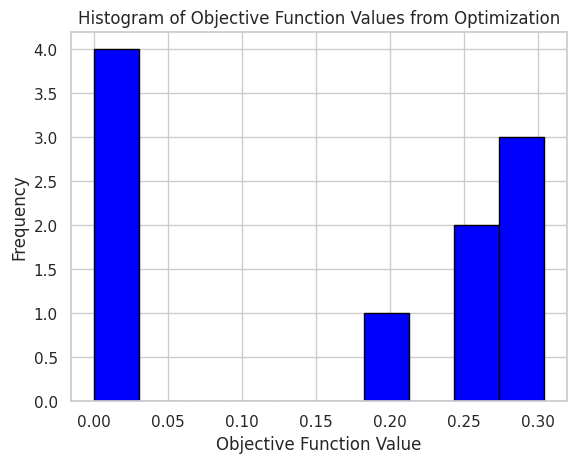

In [33]:
#apply random rotation as well as trasnlation and optimize for that

def objective_function(transformation_vector, initial_pc=initial_pc, reference_pc=reference_pc):
    """Objective function that optimizes both rotation and translation."""
    transformation_matrix = build_transformation_matrix(transformation_vector[:3], transformation_vector[3:])
    transformed_pc = transform_point_cloud_numpy(initial_pc, transformation_matrix)
    loss = chamfer_distance(transformed_pc, reference_pc)
    return loss

reference_pc = point_cloud_list['2x'][0].copy()  # Reference point cloud
initial_pc = transform_point_cloud_numpy(reference_pc.copy(),build_transformation_matrix(np.random.uniform(-np.pi, np.pi, 3), np.random.uniform(-3, 3, 3)))
display_point_clouds([reference_pc, initial_pc], ['Target', 'Randomly Transformed (Pre-Optimization)'], num_cols=2)

results = []
for _ in range(10):
    initial_params = np.random.uniform(-np.pi, np.pi, 6)  # Random initialization
    bounds = [(-np.pi, np.pi)] * 3 + [(-5, 5)] * 3  # Set bounds for each parameter
    result = minimize(objective_function, initial_params, args=(initial_pc, reference_pc),
                      bounds=bounds, method='L-BFGS-B')
    results.append(result.fun)

# Plotting the histogram of the optimization results
plt.hist(results, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Objective Function Values from Optimization')
plt.xlabel('Objective Function Value')
plt.ylabel('Frequency')
plt.show()

In [34]:
#plot the optimized point clouds
optimized_point_clouds = []

[8.377309456520829e-08, 0.2714597563094915, 0.3044093438643961, 0.30440938220307995, 0.2714601316387764, 1.2017668912861037e-07, 1.114318412666843e-07, 0.3022696063142211, 7.068180979377633e-08, 0.19552268151041408]
